# Нейронні мережі

## Опис

В цій лабораторній ви будете працювати з набором даних [California Housing](https://www.kaggle.com/datasets/camnugent/california-housing-prices?resource=download), що використовується [Google](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) і OpenAI. 

## Підготовка

In [16]:
%%capture
%pip install pandas numpy seaborn matplotlib tensorflow

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

%matplotlib inline

## Завантаження даних

Завантажемо окремі файли `.csv` і створемо наступні два `DataFrame`:
* `train_df`, який містить навчальний набір
* `test_df`, який містить тестовий набір

In [18]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # перемішуємо приклади
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

## Попередня обробка даних
Перед моделюванням ми створимо шари попередньої обробки даних, використавши три ознаки:

* широта (`latitude`) X довгота (`longitude`) (комбінована ознака)
* середній дохід (`median_income`)
* населення (`population`)

In [19]:
from tensorflow.keras.layers import Input, Normalization, Discretization, HashedCrossing, Concatenate

inputs = {
    'latitude': Input(shape=(1,), dtype=tf.float32, name='latitude'),
    'longitude': Input(shape=(1,), dtype=tf.float32, name='longitude'),
    'median_income': Input(shape=(1,), dtype=tf.float32, name='median_income'),
    'population': Input(shape=(1,), dtype=tf.float32, name='population')
}

# Створимо шар Normalization, щоб нормалізувати дані median_income
median_income = Normalization(name='normalization_median_income', axis=None)
median_income.adapt(train_df['median_income'])
median_income = median_income(inputs.get('median_income'))

# Створимо шар Normalization, щоб нормалізувати дані population.
population = Normalization(name='normalization_population', axis=None)
population.adapt(train_df['population'])
population = population(inputs.get('population'))

# Створимо список чисел, що представляють межі сегментів для широти.
# Оскільки ми використовуємо шар нормалізації, значення широти та довготи будуть приблизно в діапазоні від -3 до 3 (що відповідає Z-score).
# Ми створимо 20 сегментів, для чого необхідно мати 21 межу (отже, 20+1).
latitude_boundaries = np.linspace(-3, 3, 20+1)

# Створимо шар Normalization, щоб нормалізувати дані latitude
latitude = Normalization(name='normalization_latitude', axis=None)
latitude.adapt(train_df['latitude'])
latitude = latitude(inputs.get('latitude'))

# Створимо рівень Discretization, щоб розділити дані latitude на сегменти.
latitude = Discretization(bin_boundaries=latitude_boundaries, name='discretization_latitude')(latitude)

# Створимо список чисел, що представляють межі сегментів для довготи.
longitude_boundaries = np.linspace(-3, 3, 20+1)

# Створимо шар Normalization, щоб нормалізувати дані longitude
longitude = Normalization(name='normalization_longitude', axis=None)
longitude.adapt(train_df['longitude'])
longitude = longitude(inputs.get('longitude'))

# Створимо рівень Discretization, щоб розділити дані longitude на сегменти.
longitude = Discretization(bin_boundaries=longitude_boundaries, name='discretization_longitude')(longitude)

# Об’єднаємо ознаки широти та довготи в один one-hot вектор.
# num_bins можна регулювати: вищі значення покращують точність, менші значення покращують продуктивність
feature_cross = HashedCrossing(
    num_bins=len(latitude_boundaries) * len(longitude_boundaries),
    output_mode='one_hot',
    name='cross_latitude_longitude')([latitude, longitude])

# Об’єднаємо наші вхідні дані в один шар.
preprocessing_layers = Concatenate()([feature_cross, median_income, population])

## Модель лінійної регресії як базис

Перш ніж створювати нейронну мережу, знайдемо базову помилку, створивши просту модель лінійної регресії, яка буде використовувати створені нами шари попередньої обробки.

> Примітка: створимо її викорситавши нейронну мережу з 1 нейроном

In [20]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse_training, label="Training Loss")
  plt.plot(epochs, mse_validation, label="Validation Loss")

  merged_mse_lists = mse_training.tolist() + mse_validation
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  top_of_y_axis = highest_loss * 1.03
  bottom_of_y_axis = lowest_loss * 0.97

  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.legend()
  plt.show()

In [21]:
# Створимо шари Normalization для нормалізації даних median_house_value.
# Оскільки median_house_value є нашою міткою (тобто цільовим значенням, яке ми прогнозуємо), ці шари не будуть додані до нашої моделі.
train_median_house_value_normalized = Normalization(axis=None)
train_median_house_value_normalized.adapt(
    np.array(train_df['median_house_value']))

test_median_house_value_normalized = Normalization(axis=None)
test_median_house_value_normalized.adapt(
    np.array(test_df['median_house_value']))

In [22]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError

# Наступні змінні є гіперпараметрами.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Розділимо оригінальний навчальний набір на скорочений навчальний набір і набір перевірки.
validation_split = 0.2

# Створимо Dense вихідний шар з 1 нейроном
dense_output = Dense(units=1, name='dense_output')(preprocessing_layers)

# Визначимо словник, який ми передамо до конструктора моделі.
outputs = {
    'dense_output': dense_output
}

# Створимо і скомпілюємо просту модель лінійної регресії
model = Model(inputs=inputs, outputs=outputs)

# Обʼєднаємо шари в модель, яку зможе виконати TensorFlow.
model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mean_squared_error", metrics=[MeanSquaredError()])

Epoch 1/15
14/14 [==============================] - 1s 18ms/step - loss: 0.8619 - mean_squared_error: 0.8619 - val_loss: 0.7337 - val_mean_squared_error: 0.7337
Epoch 2/15
14/14 [==============================] - 0s 5ms/step - loss: 0.6214 - mean_squared_error: 0.6214 - val_loss: 0.5417 - val_mean_squared_error: 0.5417
Epoch 3/15
14/14 [==============================] - 0s 6ms/step - loss: 0.4773 - mean_squared_error: 0.4773 - val_loss: 0.4318 - val_mean_squared_error: 0.4318
Epoch 4/15
14/14 [==============================] - 0s 6ms/step - loss: 0.4003 - mean_squared_error: 0.4003 - val_loss: 0.3772 - val_mean_squared_error: 0.3772
Epoch 5/15
14/14 [==============================] - 0s 5ms/step - loss: 0.3650 - mean_squared_error: 0.3650 - val_loss: 0.3536 - val_mean_squared_error: 0.3536
Epoch 6/15
14/14 [==============================] - 0s 6ms/step - loss: 0.3503 - mean_squared_error: 0.3503 - val_loss: 0.3439 - val_mean_squared_error: 0.3439
Epoch 7/15
14/14 [=====================

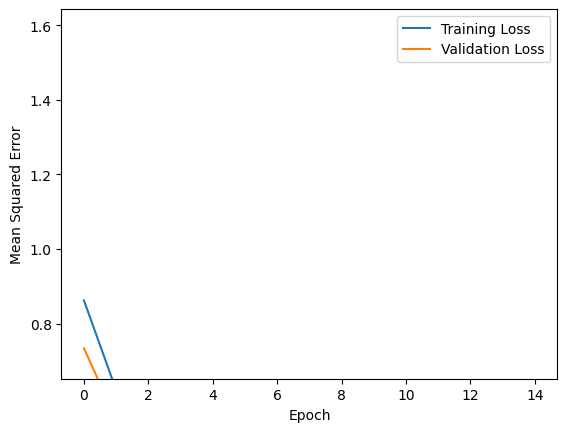


 Оцінінемо модель лінійної регресії на тестовому наборі даних:
3/3 [==============================] - 0s 9ms/step - loss: 0.3614 - mean_squared_error: 0.3614


{'loss': 0.36143553256988525, 'mean_squared_error': 0.36143553256988525}

In [23]:
import warnings
warnings.simplefilter("ignore", UserWarning)

# Навчимо модель на нормалізованому навчальному наборі.
# Розділимо набір даних на ознаки та мітку
features = {name:np.array(value) for name, value in train_df.items()}
label = train_median_house_value_normalized(np.array(features.pop(label_name)))

history = model.fit(x=features, y=label, batch_size=batch_size,
                    epochs=epochs, shuffle=True, validation_split=validation_split)

# Візьмемо дані, які будуть корисні для побудови кривої втрат.
epochs = history.epoch
hist = pd.DataFrame(history.history)
mse = hist["mean_squared_error"]

plot_the_loss_curve(epochs, mse, hist["val_mean_squared_error"])

test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(test_features.pop(label_name))
print("\n Оцінінемо модель лінійної регресії на тестовому наборі даних:")
model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

## Задача 1: Побудова багатошарової нейронної мережі

Побудуйте багатошарову нейронну мережу, що складається з 2-х схованих Dense шарів і одного вихідного Dense шару.

* 1-й схований шар повинен мати 20 нейронів, активаційну функцію `relu`, імʼя `hidden_dense_layer_1` та в якості вхідного шару використовувати наш `preprocessing_layers`.
* 2-й схований шар повинен мати 12 нейронів, активаційну функцію `relu`, імʼя `hidden_dense_layer_2` та в якості вхідного шару використовувати 1-й схований шар.
* Вихідний шар повинен мати таку ж конфігурацію як в попередній моделі регресії та в якості вхідного шару використовувати 2-й схований шар.

In [24]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError

# Наступні змінні є гіперпараметрами.
learning_rate = 0.01
epochs = 20
batch_size = 1000
label_name = "median_house_value"

# Розділимо оригінальний навчальний набір на скорочений навчальний набір і набір перевірки.
validation_split = 0.2

hidden_dense_layer_1 = Dense(20, activation='relu', name='hidden_dense_layer_1')(preprocessing_layers)
hidden_dense_layer_2 = Dense(12, activation='relu', name='hidden_dense_layer_2')(hidden_dense_layer_1)
dense_output = Dense(units=1, name='dense_output')(hidden_dense_layer_2)

# Визначимо словник, який ми передамо до конструктора моделі.
outputs = {
    'dense_output': dense_output
}

# Створимо і скомпілюємо просту модель лінійної регресії
multi_layer_model = Model(inputs=inputs, outputs=outputs)

# Обʼєднаємо шари в модель, яку зможе виконати TensorFlow.
multi_layer_model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mean_squared_error", metrics=[MeanSquaredError()])

Epoch 1/20
14/14 [==============================] - 0s 9ms/step - loss: 0.3378 - mean_squared_error: 0.3378 - val_loss: 0.3344 - val_mean_squared_error: 0.3344
Epoch 2/20
14/14 [==============================] - 0s 5ms/step - loss: 0.3375 - mean_squared_error: 0.3375 - val_loss: 0.3340 - val_mean_squared_error: 0.3340
Epoch 3/20
14/14 [==============================] - 0s 6ms/step - loss: 0.3374 - mean_squared_error: 0.3374 - val_loss: 0.3339 - val_mean_squared_error: 0.3339
Epoch 4/20
14/14 [==============================] - 0s 6ms/step - loss: 0.3373 - mean_squared_error: 0.3373 - val_loss: 0.3338 - val_mean_squared_error: 0.3338
Epoch 5/20
14/14 [==============================] - 0s 6ms/step - loss: 0.3374 - mean_squared_error: 0.3374 - val_loss: 0.3339 - val_mean_squared_error: 0.3339
Epoch 6/20
14/14 [==============================] - 0s 6ms/step - loss: 0.3374 - mean_squared_error: 0.3374 - val_loss: 0.3341 - val_mean_squared_error: 0.3341
Epoch 7/20
14/14 [======================

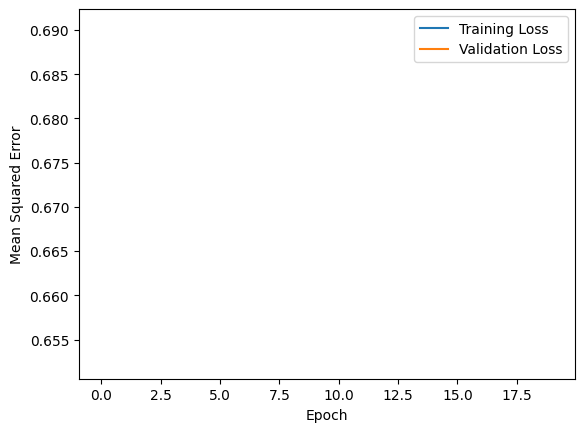


 Оцінінемо багатошарову модель на тестовому наборі даних:
3/3 [==============================] - 0s 10ms/step - loss: 0.9956 - mean_squared_error: 0.9956


{'loss': 0.99556964635849, 'mean_squared_error': 0.99556964635849}

In [25]:
multi_layer_history = model.fit(x=features, y=label, batch_size=batch_size,
                                epochs=epochs, shuffle=True, validation_split=validation_split)

# Візьмемо дані, які будуть корисні для побудови кривої втрат.
multi_layer_epochs = multi_layer_history.epoch
multi_layer_hist = pd.DataFrame(multi_layer_history.history)
multi_layer_mse = multi_layer_hist["mean_squared_error"]

plot_the_loss_curve(multi_layer_epochs, multi_layer_mse, multi_layer_hist["val_mean_squared_error"])

test_features = {name: np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(test_features.pop(label_name))

print("\n Оцінінемо багатошарову модель на тестовому наборі даних:")
multi_layer_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

Є дуже велика ймовірність, що складна модель перетренерується на тренувальному наборі і буде мати велику помилку на перевірочному. Тому...

## Задача 2: Оптимізація нейронної мережі
Поекспериментуйте з кількістю шарів нейронної мережі та кількістю вузлів у кожному шарі. В ідеалі необхідно досягти обидві наступні цілі:

* Знизити втрати на тестовому наборі.
* Мінімізувати загальну кількість вузлів у нейронній мережі.

Загалом, ці дві цілі можуть суперечити одна одній і треба знаходити компроміс, однак в нашому випадку якщо було перетренування мережі то все повинно бути добре.

Варіантів може бути багато. Але є наступні думки:
* Три шари можливо забагато і модель перетренеровується, що не дає досягти оптимального результату. Можливо два шари буде достатньо для компромісу.
* Використовуючи два шари можна поексперементувати з кількістю нейронів, наприклад 10 в першому шарі і 6 в другому, або 6 в першому і 4 в другому. Але можна і навпаки збільшити кількість нейронів.

> Примітка: Загальний код можна скопіпастити з попередніхприкладів/завдань

Epoch 1/20
14/14 [==============================] - 1s 17ms/step - loss: 0.8920 - mean_squared_error: 0.8920 - val_loss: 0.7612 - val_mean_squared_error: 0.7612
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.5992 - mean_squared_error: 0.5992 - val_loss: 0.4552 - val_mean_squared_error: 0.4552
Epoch 3/20
14/14 [==============================] - 0s 5ms/step - loss: 0.3842 - mean_squared_error: 0.3842 - val_loss: 0.3411 - val_mean_squared_error: 0.3411
Epoch 4/20
14/14 [==============================] - 0s 7ms/step - loss: 0.3398 - mean_squared_error: 0.3398 - val_loss: 0.3289 - val_mean_squared_error: 0.3289
Epoch 5/20
14/14 [==============================] - 0s 6ms/step - loss: 0.3296 - mean_squared_error: 0.3296 - val_loss: 0.3243 - val_mean_squared_error: 0.3243
Epoch 6/20
14/14 [==============================] - 0s 6ms/step - loss: 0.3251 - mean_squared_error: 0.3251 - val_loss: 0.3235 - val_mean_squared_error: 0.3235
Epoch 7/20
14/14 [=====================

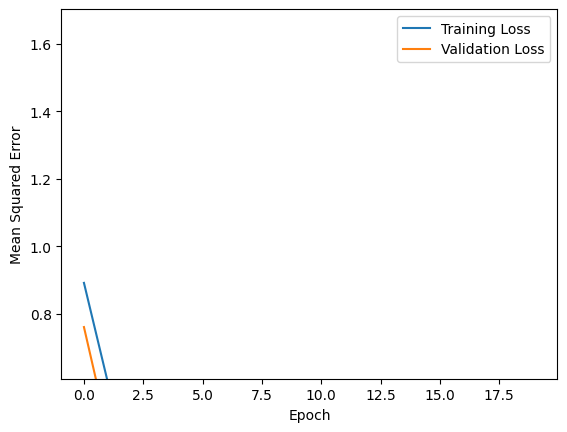


 Оцінінемо оптимізовану модель на тестовому наборі даних:
3/3 [==============================] - 0s 10ms/step - loss: 0.3460 - mean_squared_error: 0.3460


{'loss': 0.3460461497306824, 'mean_squared_error': 0.3460461497306824}

In [26]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError

# Нові гіперпараметри
hidden_units_layer1 = 10
hidden_units_layer2 = 6

hidden_dense_layer_1 = Dense(hidden_units_layer1, activation='relu', name='hidden_dense_layer_1')(preprocessing_layers)
hidden_dense_layer_2 = Dense(hidden_units_layer2, activation='relu', name='hidden_dense_layer_2')(hidden_dense_layer_1)
dense_output = Dense(units=1, name='dense_output')(hidden_dense_layer_2)

outputs = {
    'dense_output': dense_output
}

optimized_model = Model(inputs=inputs, outputs=outputs)
optimized_model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mean_squared_error", metrics=[MeanSquaredError()])

optimized_history = optimized_model.fit(x=features, y=label, batch_size=batch_size,
                                       epochs=epochs, shuffle=True, validation_split=validation_split)

optimized_epochs = optimized_history.epoch
optimized_hist = pd.DataFrame(optimized_history.history)
optimized_mse = optimized_hist["mean_squared_error"]

plot_the_loss_curve(optimized_epochs, optimized_mse, optimized_hist["val_mean_squared_error"])

print("\n Оцінінемо оптимізовану модель на тестовому наборі даних:")
optimized_model.evaluate(x=test_features, y=test_label, batch_size=batch_size, return_dict=True)